# Exploring President Trump's Daily Task Force Briefings with Emotion Analysis and Topic Modelling

![alt text](../imgs/trump_task_force.jpg)

Given the controversy over the Trump administration's [daily briefings](https://www.nytimes.com/2020/04/09/us/politics/trump-coronavirus-press-briefing.html?referringSource=articleShare) and overall [handling of the COVID-19 pandemic in general](https://www.nytimes.com/2020/04/14/us/politics/coronavirus-trump-who-funding.html), I thought it would be interesting to apply some of the basic NLP techniques I recently learned to explore this timely, readily available body of text. The analysis below explores all of the White House's task force briefings held from 2020-02-26 to 2020-04-27.

### Scraping Briefing Transcripts
Although the briefing transcripts are available on [rev.com](https://www.rev.com) in formatted `.txt` files, I wanted to practice using [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) for web scraping as part of this project. The scraped transcripts are included [here](https://github.com/brendoncampbell/corona-briefing-tones/blob/master/data/all_briefings.csv), and [`scrape_briefings.py`](https://github.com/brendoncampbell/corona-briefing-tones/blob/master/src/scrape_briefings.py) can be run to rescrape them.

After reading in this relatively clean CSV, we have a simple dataframe containing chronological paragraphs of speech `text` along with the corresponding `date`, `timestamp` and `speaker`:

In [1]:
import pandas as pd
import numpy as np
import altair as alt

In [2]:
alt.renderers.enable('png')
#alt.renderers.enable('mimetype')

RendererRegistry.enable('png')

In [3]:
# import scraped csv to pandas df
briefings_df = pd.read_csv('../data/all_briefings.csv')
briefings_df

,date,timestamp,speaker,text
0,2020-02-26,05:39,Donald Trump,Thank you very much everybody. Thank you very ...
1,2020-02-26,06:59,Donald Trump,A lot of people thought we shouldn’t have done...
2,2020-02-26,07:51,Donald Trump,We have a total of 15. We took in some from Ja...
3,2020-02-26,09:58,Donald Trump,China you know about. Where it started. I spok...
4,2020-02-26,10:52,Donald Trump,"We’re bringing in a specialist, a very highly ..."
...,...,...,...,...
9677,2020-04-27,01:01:23,Reporters,[crosstalk 00:13:23].
9678,2020-04-27,01:01:24,Donald Trump,"Let’s do one more. Please, in the back."
9679,2020-04-27,01:01:26,Speaker 16,If an American president loses more Americans ...
9680,2020-04-27,01:01:36,Donald Trump,"So yeah, we’ve lost a lot of people, but if yo..."


### Null Values
Checking for null values, we can see there are actually only three missing `text` values in the near 10,000 rows. 

In [4]:
briefings_df[briefings_df['text'].isnull()]

,date,timestamp,speaker,text
7217,2020-04-13,16:03,Donald Trump,NaN
8339,2020-04-19,23:03,Andrew Cuomo,NaN
9181,2020-04-22,01:15:03,Dr. Birx,NaN


A quick look at the full transcripts and video recordings confirms these correspond to the speaker interjecting, being cut off, or uttering something inaudible. For the purpose of this analysis, let's simply drop these:

In [5]:
briefings_df = briefings_df.dropna(subset=['text']).reset_index(drop=True)

### Cleaning Up Speaker Names

Checking the names of the most frequent speakers, we see a few opportunities to clean up this column before moving on to preprocessing.

1. Unnamed speakers identified by a number (i.e. `Speaker 12`) are reset for each briefing, and therefore don't map to the same person.
2. President Trump and some of the other key task force members are referenced by multiple names (`Dr. Birx`, `Dr. Deborah Birx`)
3. There are a handful of male reporters (John, Jeff, Jim, Peter, and Steve) frequently called upon by their first name

In [6]:
# how many paragraphs of text for the top speakers?
briefings_df['speaker'].value_counts()[:40]

Donald Trump              4013
Mike Pence                 751
Dr. Birx                   244
Dr. Fauci                  237
John                       161
Deborah Birx               101
Dr. Deborah Birx            94
Admiral Giroir              94
Speaker 8                   93
Speaker 7                   92
Speaker 5                   88
Steve Mnuchin               84
Speaker 12                  82
Speaker 11                  82
Speaker 22                  79
Speaker 3                   78
Speaker 9                   76
Speaker 10                  76
Speaker 4                   73
Speaker 6                   73
Speaker 13                  72
Speaker 14                  68
Speaker 2                   65
Speaker 19                  64
Speaker 15                  61
Speaker 16                  60
Mike Pompeo                 59
Reporter                    58
Jeff                        56
Vice President Pence        53
Speaker 18                  52
Speaker 23                  52
Speaker 

Let's consolidate these so we have consistent speaker names:

In [7]:
# replace speaker names using basic regex
briefings_df['speaker'].replace(regex={r'.*Trump.*': 'Donald Trump', 
                                       r'.*Pence.*': 'Mike Pence',
                                       r'.*Fauci.*': 'Dr. Anthony Fauci',
                                       r'.*Birx.*': 'Dr. Deborah Birx',
                                       r'.*Berks.*': 'Dr. Deborah Birx',
                                       r'.*Pompeo.*': 'Mike Pompeo',
                                       r'.*Report.*': 'Unnamed (Reporter)',
                                       r'.*Audience Member.*': 'Unnamed',
                                       r'.*Speaker .*': 'Unnamed', 
                                       r'.*Jeff\Z': 'Jeff (Reporter)',
                                       r'.*John\Z': 'John (Reporter)',
                                       r'.*Peter\Z': 'Peter (Reporter)',
                                       r'.*Jim\Z': 'Jim (Reporter)',
                                       r'.*Steve\Z': 'Steve (Reporter)',
                                       r'.*Pete\Z': 'Pete Gaynor',
                                       r'.*Novarro.*': 'Peter Navarro',
                                       r'.*Surgeon General.*': 'Jerome Adams',
                                       r'.*Giroir.*': 'Brett Giroir',
                                       r'.*Polowczyk.*': 'John Polowczyk',
                                       r'.*Verma.*': 'Seema Verma',
                                       r'.*Azar.*': 'Alex Azar',
                                       r'.*Hahn.*': 'Dr. Steven Hahn',
                                       r'.*Mnuchin.*': 'Steve Mnuchin'},
                                inplace = True)

briefings_df['speaker'].value_counts()[:20]

Donald Trump          4091
Unnamed               2038
Mike Pence             849
Dr. Deborah Birx       491
Dr. Anthony Fauci      317
Unnamed (Reporter)     215
John (Reporter)        162
Steve Mnuchin          136
Brett Giroir           100
Mike Pompeo             81
Dr. Steven Hahn         64
Alex Azar               63
Seema Verma             56
Jeff (Reporter)         56
John Polowczyk          49
Jerome Adams            48
Jim (Reporter)          47
Steve (Reporter)        46
Peter Navarro           35
Peter (Reporter)        33
Name: speaker, dtype: int64

### Preprocessing Text

Language is inherently unstructured compared to most types of data, so we need to preprocess the text before moving onto analysis. We will carry out this preprocessing and normalize things somewhat using the [spaCy](https://spacy.io) package:

1. Convert text to lower-cas 
2. Tokenize (identify word boundaries and split text)
3. Remove stop words (frequently-occurring English words that don't tend to be useful for analysis)
4. Lemmatize (convert words to their base form: spreading → spread)
5. Exclude irrelevant tokens such as emails, URLS and unimportant parts of speech (i.e. pronouns, conjunctions, punctuation)

In [8]:
import spacy
from pandarallel import pandarallel
import re

In [9]:
# Load English spaCy model and stop words
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS

# function for preprocessing each paragraph of transcript text
def preprocess(text, 
               min_token_len = 2, 
               irrelevant_pos = ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE']): 
    """
    Carry out preprocessing of the text and return a preprocessed list of strings. 
    
    Parameters
    -------------
    text : (str) 
        the text to be preprocessed
    min_token_len : (int) 
        min_token_length required
    irrelevant_pos : (list) 
        a list of irrelevant pos tags
    
    Returns
    -------------
    (list) the preprocessed text as a list of strings
    """
    
    # convert input string to lowercase
    text = text.lower()

    # remove multiple whitespace characters
    text = re.sub(r'\s+',' ', text)
    
    # tokenize with spacy, exluding stop words, short tokens, 
    # irrelevant POS, emails, urls, and strings containing 
    # non-alphanumeric chars
    
    doc = nlp(text)
    token_list = []
    for token in doc:
        if token.is_stop == False and len(token.text)>=min_token_len \
            and token.pos_ not in irrelevant_pos and token.like_email == False \
            and token.like_url == False and token.text.isalnum():
            token_list.append(token.lemma_)
        
    return token_list

Applying the `preprocess()` function defined above to each briefing text:

In [10]:
# parallelize and apply preprocessor to each text
pandarallel.initialize(verbose=False)
briefings_df['pp_text'] = briefings_df.text.parallel_apply(preprocess)
briefings_df['pp_text']

0       [thank, thank, begin, like, extend, deep, cond...
1       [lot, people, think, turn, good, thing, number...
2       [total, 15, take, japan, hear, american, citiz...
3       [china, know, start, speak, president, xi, gre...
4       [bring, specialist, regarded, specialist, tomo...
                              ...                        
9674                                          [crosstalk]
9675                                                [let]
9676    [american, president, lose, americans, course,...
9677    [yeah, lose, lot, people, look, original, proj...
9678    [press, talk, ventilator, want, talk, okay, re...
Name: pp_text, Length: 9679, dtype: object

### Emotion and Sentiment Analysis

Now that we have a nice clean dataframe to work with, it's time to move on to analysis. Rather than applying the popular [TextBlob](https://textblob.readthedocs.io/en/dev/) or [Vader](https://github.com/cjhutto/vaderSentiment) packages commonly used for sentiment analysis, I thought it would be interesting to also explore the emotional tone of briefing texts.

Let's see what we can uncover using the NRC Word-Emotion Association Lexicon, [EmoLex](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm). In addition to 'positive' and 'negative', we have word associations for eight basic emotion categories.

In [11]:
# read in raw emotion lexicon
filepath = "../NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=1, sep='\t')

# pivot df so we have one row per word, one column per emotion
emolex_df = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()
emolex_df.columns.name = 'index'

# filter out words without scores, as well as those with more than 7 scores
emolex_df = emolex_df[emolex_df.sum(axis=1)>0].reset_index(drop=True)
emolex_df = emolex_df[emolex_df.sum(axis=1)<7].reset_index(drop=True)
emolex_df

index,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,abacus,0,0,0,0,0,0,0,0,0,1
1,abandon,0,0,0,1,0,1,0,1,0,0
2,abandoned,1,0,0,1,0,1,0,1,0,0
3,abandonment,1,0,0,1,0,1,0,1,1,0
4,abba,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6437,zany,0,0,0,0,0,0,0,0,1,0
6438,zeal,0,1,0,0,1,0,1,0,1,1
6439,zealous,0,0,0,0,1,0,1,0,0,1
6440,zest,0,1,0,0,1,0,1,0,0,1


We can now use this lexicon to easily retrieve associations for the words in a single briefing `text`:

In [12]:
paragraph_text = briefings_df.text[504]
print(paragraph_text)

Thank you, Mr. President. We just completed today’s meeting of the White House coronavirus task force. We had the opportunity to brief the President today on a broad range of issues. Once again, because of the unprecedented action that President Trump took in January, suspending all travel from China, establishing travel advisories for portions of South Korea and Italy, establishing screening of all direct flights, all passengers from all airports, Italy and South Korea… we have bought a considerable amount of time, according to all the health experts, to deal with the coronavirus here in the United States.


In [13]:
paragraph_tokens = briefings_df.pp_text[504]
print(paragraph_tokens)

['thank', 'mr', 'president', 'complete', 'today', 'meeting', 'white', 'house', 'coronavirus', 'task', 'force', 'opportunity', 'brief', 'president', 'today', 'broad', 'range', 'issue', 'unprecedented', 'action', 'president', 'trump', 'take', 'january', 'suspend', 'travel', 'china', 'establish', 'travel', 'advisory', 'portion', 'south', 'korea', 'italy', 'establish', 'screening', 'direct', 'flight', 'passenger', 'airport', 'italy', 'south', 'korea', 'buy', 'considerable', 'time', 'accord', 'health', 'expert', 'deal', 'coronavirus', 'united', 'states']


In [14]:
emolex_df[pd.DataFrame(emolex_df.word.tolist()).isin(paragraph_tokens).any(1)]

index,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
55,accord,0,0,0,0,0,0,1,0,0,1
80,action,0,0,0,0,0,0,1,0,0,0
174,airport,0,1,0,0,0,0,0,0,0,0
1182,considerable,0,0,0,0,0,0,1,0,0,0
1460,deal,0,1,0,0,1,0,1,0,1,1
2098,establish,0,0,0,0,0,0,0,0,0,1
2184,expert,0,0,0,0,0,0,1,0,0,1
2392,force,1,0,0,1,0,1,0,0,0,0
4088,opportunity,0,1,0,0,0,0,1,0,0,0
4209,passenger,0,1,0,0,0,0,0,0,0,0


Following this approach, let's calculate and store aggregate emotion scores for each briefing paragraph:

In [15]:
# create empty df to store aggregated emotion calcs
data = pd.DataFrame([])

for tokens in briefings_df['pp_text']:
    paragraph_emos = emolex_df[pd.DataFrame(emolex_df.word.tolist()).isin(tokens).any(1)].mean()
    data = data.append(paragraph_emos, ignore_index=True)
    
# combine aggregated emotion scores with transcript df
briefings_df = briefings_df.join(data)

# drop empty 'word' column, fill NaNs with zero
briefings_df = briefings_df.drop(columns=['word'])
briefings_df = briefings_df.fillna(0)

briefings_df.head()

,date,timestamp,speaker,text,pp_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,2020-02-26,05:39,Donald Trump,Thank you very much everybody. Thank you very ...,"[thank, thank, begin, like, extend, deep, cond...",0.428571,0.071429,0.214286,0.428571,0.142857,0.571429,0.285714,0.428571,0.142857,0.071429
1,2020-02-26,06:59,Donald Trump,A lot of people thought we shouldn’t have done...,"[lot, people, think, turn, good, thing, number...",0.111111,0.444444,0.111111,0.333333,0.111111,0.333333,0.444444,0.222222,0.111111,0.333333
2,2020-02-26,07:51,Donald Trump,We have a total of 15. We took in some from Ja...,"[total, 15, take, japan, hear, american, citiz...",0.187500,0.312500,0.062500,0.250000,0.187500,0.250000,0.437500,0.250000,0.250000,0.187500
3,2020-02-26,09:58,Donald Trump,China you know about. Where it started. I spok...,"[china, know, start, speak, president, xi, gre...",0.083333,0.250000,0.000000,0.083333,0.250000,0.250000,0.666667,0.000000,0.083333,0.500000
4,2020-02-26,10:52,Donald Trump,"We’re bringing in a specialist, a very highly ...","[bring, specialist, regarded, specialist, tomo...",0.272727,0.090909,0.181818,0.545455,0.000000,0.636364,0.181818,0.454545,0.272727,0.090909


### Topic Modelling

Now that we have emotion and sentiment scores, let's apply topic modelling to see if we can identify the major themes discussed during the briefings and classify each briefing `text` accordingly. We'll use the [gensim](https://pypi.org/project/gensim/) package to build a Latent Dirichlet Allocation (LDA) model.

In [16]:
import gensim.corpora as corpora
from gensim import models
import pyLDAvis.gensim

First, we create a dictionary of all of the word tokens we consider relevant for topic modelling:

In [17]:
# build dictionary
corpus = briefings_df['pp_text'].tolist()
dictionary = corpora.Dictionary(corpus)

# filter extremes, removing tokens that appear in either:
# fewer than 10 texts, or in more than 10% of all tets
dictionary.filter_extremes(no_below = 10, no_above = 0.1)

# define words to be manually removed and retrieve their indexes
remove_words = ['crosstalk', 'question', 'inaudible', 'mr', 'sir', 'dr']
del_indexes = [k for k,v in dictionary.items() if v in remove_words]

# remove unwanted word ids from the dictionary
dictionary.filter_tokens(bad_ids=del_indexes)

Next, a [document-term co-occurrence matrix](https://en.wikipedia.org/wiki/Document-term_matrix), consisting of the bag-of-words (BoW) representation of each `text`:

In [18]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]

With both of these, we can build and visualize an LDA topic model:

In [19]:
lda_model = models.LdaModel(corpus=doc_term_matrix,
                            id2word=dictionary,
                            num_topics=6,
                            passes=20,
                            random_state=123)

In [20]:
viz = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary, sort_topics=False)

# enable for interactive topic model visualization:
#    pyLDAvis.enable_notebook()
#    viz

After inspecting the interactive output rendered by [pyLDAvis](https://github.com/bmabey/pyLDAvis), experimenting with different numbers of topics, and filtering some unhelpful and extreme tokens, we see logical results with the following six topics being identified:
1. Economy
2. International
3. Policy & Guidelines
4. Testing
5. Ventilators & NY Outbreak
6. Personal Protective Equipment (PPE)

![alt text](../imgs/topics.png)

Now let's use the topic model to predict the topic for each individual `text`:

In [21]:
topic_labels = {0:'Economy',
                1:'International',
                2:'Policy & Guidelines',
                3:'Testing',
                4:'Ventilators & NY Outbreak',
                5:'PPE'
               }

In [22]:
def get_most_prob_topic(unseen_document, model = lda_model):
    """
    Given an unseen_document, and a trained LDA model, this function
    finds the most likely topic (topic with the highest probability) from the 
    topic distribution of the unseen document and returns the best topic
    
    Parameters
    ------------
    unseen_document : (str) 
        the document to be labeled with a topic
    model : (gensim ldamodel) 
        the trained LDA model
    
    Returns: 
    -------------
        (str) the most likely topic label
    
    Examples:
    ----------
    >> get_most_prob_topic("We're building so so so many ventilators.", 
                            model = lda)
    Ventilators
    """
    
    # preprocess unseen text and obtain bow vector
    unseen_doc_pp = preprocess(unseen_document)
    bow_vector = dictionary.doc2bow(unseen_doc_pp)
    
    # calculate topic scores for unseen text
    scores_df = pd.DataFrame(lda_model[bow_vector], columns =['topic', 'score']) 
    
    # find topic name of max score
    topic_name = topic_labels[scores_df.loc[scores_df['score'].idxmax(), 'topic']]
    best_score = scores_df['score'].max()
    
    return topic_name, best_score;

In [23]:
# create empty lists to store prediction strings
predictions = []
scores = []

# call function for each unseen text, appending predictions to list
for text in briefings_df['pp_text'].tolist():
    # only predict a topic for texts where there are 4 or more tokens
    if len(text) > 4:
        topic, value = get_most_prob_topic(' '.join(text))
        predictions.append(topic)
        scores.append(value)
    else:
        predictions.append(np.nan)
        scores.append(np.nan)

# add prediction values to main df
briefings_df['topic_pred'] = predictions
briefings_df['topic_score'] = scores

# save scored df to csv
briefings_df.to_csv("../data/scored_briefings.csv",index=False)

briefings_df[['pp_text','topic_pred','topic_score']].head()

,pp_text,topic_pred,topic_score
0,"[thank, thank, begin, like, extend, deep, cond...",International,0.544385
1,"[lot, people, think, turn, good, thing, number...",Policy & Guidelines,0.573967
2,"[total, 15, take, japan, hear, american, citiz...",International,0.337955
3,"[china, know, start, speak, president, xi, gre...",International,0.599763
4,"[bring, specialist, regarded, specialist, tomo...",Testing,0.322573


## Analysis and Visualization

As anyone following along might expect, we see that the briefings tend to strike a more positive than negative tone.


- "When I started out I suspected we might see some clearer trends over time."
- Show plot for the emotions? 
- Add a note on time series analysis vs treating briefing date as ordinal

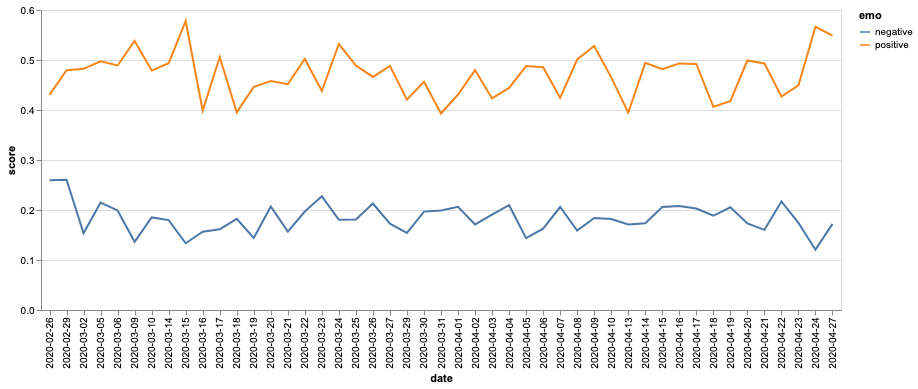

In [24]:
# ALL SPEAKERS, TRY TO FACET BY SPEAKERS?

briefings_by_date = briefings_df.groupby(['date']).mean().reset_index()
sentiment_by_date = briefings_by_date[['positive', 'negative', 'date']]
sentiment_by_date = sentiment_by_date.melt(['date'], var_name='emo', value_name='score')


alt.Chart(sentiment_by_date).mark_line().encode(
    x='date:O',
    y='score:Q',
    color='emo:N'
).properties(width = 800)

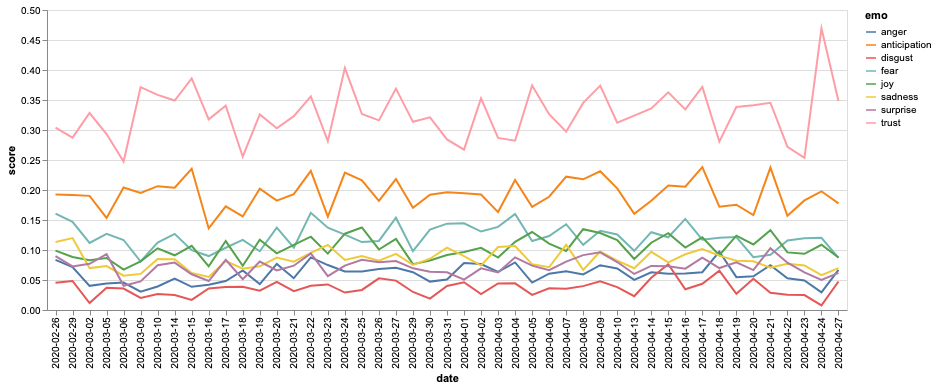

In [25]:
emotion_by_date = briefings_by_date.drop(columns=['topic_score', 'positive', 'negative'])
emotion_by_date = emotion_by_date.melt(['date'], var_name='emo', value_name='score')
emotion_by_date

alt.Chart(emotion_by_date).mark_line().encode(
    x='date:O',
    y='score:Q',
    color='emo:N'
).properties(width = 800)

In [26]:
# strong fear and sadness scores on 2020-04-16
briefings_by_date.sort_values(by='fear', ascending=False).head(5)

,date,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,topic_score
15,2020-03-22,0.087568,0.231835,0.040246,0.162040,0.122133,0.196973,0.501910,0.095169,0.094293,0.355948,0.592209
0,2020-02-26,0.083491,0.192683,0.045268,0.160710,0.099012,0.259590,0.430136,0.113447,0.089720,0.304056,0.602664
27,2020-04-04,0.079283,0.216782,0.044421,0.160031,0.113695,0.209564,0.444201,0.106694,0.087797,0.282138,0.622099
20,2020-03-27,0.070379,0.218151,0.048977,0.153848,0.118637,0.172740,0.487975,0.093499,0.081705,0.368970,0.566977
37,2020-04-16,0.060887,0.205436,0.034602,0.151805,0.104081,0.208135,0.493181,0.092934,0.068970,0.334371,0.589919


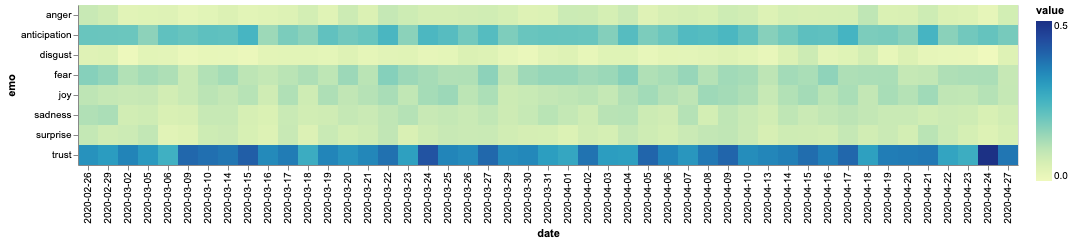

In [27]:
speaker_feels = briefings_df
speaker_feels = speaker_feels.drop(columns=['topic_score', 'positive', 'negative'])
speaker_feels_by_date = speaker_feels.groupby(['date']).mean().reset_index()
speaker_feels_by_date = speaker_feels_by_date.melt('date', var_name='emo', value_name='value')


alt.Chart(speaker_feels_by_date).mark_rect().encode(
    x='date:O',
    y='emo:N',
    color='value:Q'
)

In [28]:
# plot heatmap by date for a speaker

def emo_date_heatmap(speaker):
    speaker_feels = briefings_df[briefings_df['speaker']==speaker]
    speaker_feels = speaker_feels.drop(columns=['topic_score', 'positive', 'negative'])
    speaker_feels_by_date = speaker_feels.groupby(['date']).mean().reset_index()
    speaker_feels_by_date = speaker_feels_by_date.melt('date', var_name='emo', value_name='value')


    plot = alt.Chart(speaker_feels_by_date).mark_rect().encode(
        x='date:O',
        y='emo:N',
        color='value:Q'
    ).properties(title = speaker)
    
    return plot

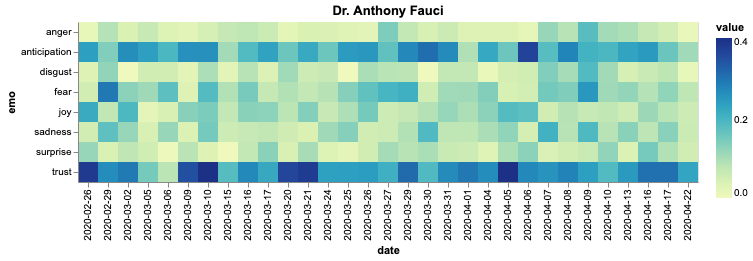

In [29]:
emo_date_heatmap('Dr. Anthony Fauci')

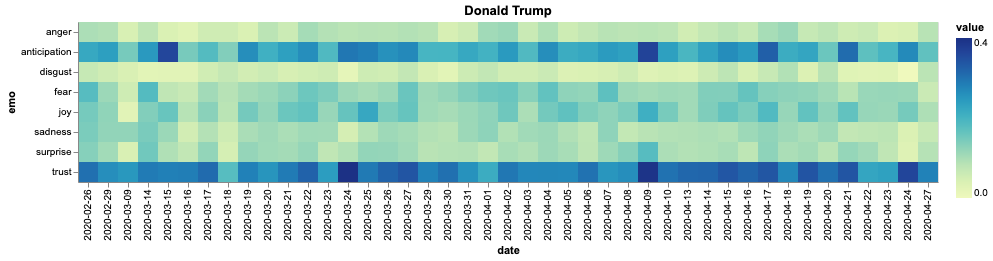

In [30]:
emo_date_heatmap('Donald Trump')

### Topics:

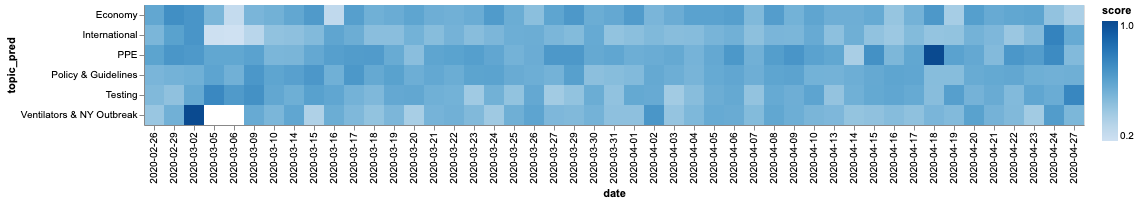

In [31]:
topics_by_date = briefings_df.groupby(['topic_pred', 'date']).mean().reset_index()
topics_by_date = topics_by_date.melt(['topic_pred', 'date'], var_name='emo', value_name='score')

alt.Chart(topics_by_date[topics_by_date['emo'] == 'positive']).mark_rect().encode(
    alt.X('date:O'),
    alt.Y('topic_pred:O'),
    alt.Color('score:Q', scale=alt.Scale(scheme='blues'))
)

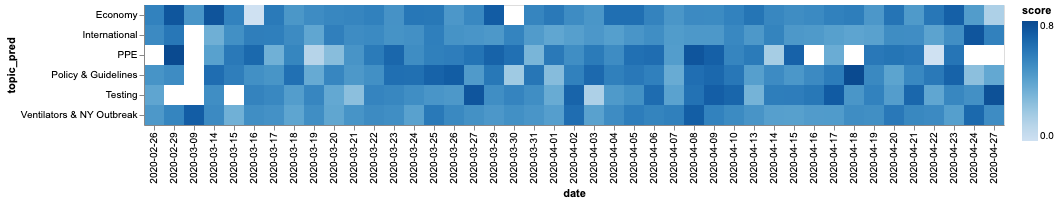

In [32]:
trump_briefings_df = briefings_df[briefings_df['speaker'] == 'Donald Trump']
trump_topics_by_date = trump_briefings_df.groupby(['topic_pred', 'date']).mean().reset_index()
trump_topics_by_date = trump_topics_by_date.melt(['topic_pred', 'date'], var_name='emo', value_name='score')

alt.Chart(trump_topics_by_date[trump_topics_by_date['emo'] == 'positive']).mark_rect().encode(
    alt.X('date:O'),
    alt.Y('topic_pred:O'),
    alt.Color('score:Q', scale=alt.Scale(scheme='blues'))
)

### Scratchpad for other ideas:

In [33]:
# query for specific terms rather than topics
# chloroquine, ventilator, remdesivir etc

briefings_df[briefings_df['text'].str.contains("China")][100:110]

,date,timestamp,speaker,text,pp_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,topic_pred,topic_score
2128,2020-03-20,01:06:25,Unnamed,[crosstalk 01:06:25] I have two questions. The...,"[crosstalk, question, secretary, pompeo, news,...",0.000000,0.285714,0.000000,0.142857,0.000000,0.285714,0.428571,0.000000,0.000000,0.000000,International,0.558708
2133,2020-03-20,01:07:18,Mike Pompeo,May I just say one more thing. There’s been so...,"[thing, discussion, china, know, know, critica...",0.076923,0.153846,0.000000,0.307692,0.153846,0.384615,0.538462,0.153846,0.076923,0.230769,Policy & Guidelines,0.358709
2134,2020-03-20,01:08:02,Mike Pompeo,"This is absolutely, this transparency, this re...","[transparency, realtime, information, sharing,...",0.250000,0.166667,0.166667,0.250000,0.166667,0.416667,0.583333,0.166667,0.000000,0.250000,Policy & Guidelines,0.468484
2147,2020-03-20,01:11:27,Dr. Anthony Fauci,"Thank you, Mr. President. First of all, I thin...","[thank, mr, president, think, false, equivalen...",0.142857,0.285714,0.000000,0.285714,0.000000,0.285714,0.428571,0.285714,0.142857,0.428571,International,0.602451
2224,2020-03-20,01:32:32,Dr. Anthony Fauci,The possibility of aerosol transmission always...,"[possibility, aerosol, transmission, come, sit...",0.000000,0.250000,0.125000,0.250000,0.000000,0.375000,0.125000,0.000000,0.000000,0.250000,International,0.487770
2375,2020-03-21,01:03:19,Donald Trump,"Well, I love whoever you’re with that’s becaus...","[love, think, nice, nice, question, think, was...",0.166667,0.083333,0.166667,0.000000,0.083333,0.333333,0.416667,0.166667,0.083333,0.166667,International,0.869140
2377,2020-03-21,01:05:01,Donald Trump,That’s the game. Win with as few lives lost as...,"[game, win, life, lose, possible, tough, enemy...",0.555556,0.111111,0.333333,0.333333,0.111111,0.777778,0.111111,0.333333,0.111111,0.222222,International,0.570702
2399,2020-03-21,01:09:52,Donald Trump,"When I learned I started doing the closing, so...","[learn, start, closing, time, learn, think, go...",0.000000,0.500000,0.000000,0.000000,0.166667,0.000000,0.666667,0.000000,0.000000,0.333333,International,0.965033
2402,2020-03-21,01:10:37,Donald Trump,They didn’t have that time. They read about it...,"[time, read, newspaper, like, china, secretive...",0.000000,0.285714,0.000000,0.142857,0.285714,0.428571,0.428571,0.285714,0.000000,0.428571,International,0.869386
2407,2020-03-21,01:11:21,Unnamed,Because as you were saying China was extremely...,"[say, china, secretive, advisor, critical, chi...",0.000000,0.200000,0.000000,0.000000,0.000000,0.200000,0.600000,0.000000,0.000000,0.200000,International,0.487411


In [34]:
for i in briefings_df.sort_values(by='topic_score', ascending=False)['text'].head(5):
    print(i)
    print()

Dr Fauci spoke about it yesterday and we’ll reflect on his perspective on that as well. Tomorrow with the surgeon general and others on the White House team, we’ll be speaking with leaders in the African American community and as Dr Fauci will reflect, there have been historic challenges in the healthcare of the African African American communities. Particularly in our inner cities and now more than ever, I’ll just say from my heart to all of our African American family members now more than ever, practice the guidelines. Look after those most vulnerable people that have underlying serious health conditions. It’s more important than ever that we all put those principles into practice. Finally today, after we hear from Dr Fauci and Dr. Birx, I’m going to ask Dr Redfield to step up because today the CDC will be publishing new guidance on essential critical workers who have been exposed to COVID-19 but don’t have any symptoms. Don’t have a temperature and don’t have any reason to believe 

- get_most_prob_topic() function doesn't need to call preprocess()

- Compare line plot to vader
- revisit emotion calcs: index 2377 "That's the game" is a good one to check out.
- calculate emotion scores for the entire briefing
- parallelize/`apply` the emotion evaluation similar to the preprocessing in topic modelling

- Nans instead of None
> how sentiments/topics compare between speaker

> how sentiments/topics have evolved over the pandemic.   

> SHOW MOST FEARFUL/ANGRY PORTIONS

> filter out the topic predictions below a certain strength ?

> Specific dates: April 13th, total authority. 

> Reporters tones

In [35]:


# https://www.rev.com/blog/transcript-tag/andrew-cuomo-transcripts/page/5
    
# https://www.rev.com/blog/transcript-tag/canada-coronavirus-briefing-transcripts/page/3

In [36]:
briefings_df[briefings_df['timestamp'] == '01:19:06']

,date,timestamp,speaker,text,pp_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,topic_pred,topic_score
7392,2020-04-13,01:19:06,Donald Trump,"When you say my authority, the president’s aut...","[authority, president, authority, president, u...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,PPE,0.48874
